<h1>Prueba Técnica Laude<h1>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_BS_info = pd.read_csv('ITU-5G-energy-Consumption-Dataset/BSinfo.csv')
df_CL_data = pd.read_csv('ITU-5G-energy-Consumption-Dataset/CLdata.csv')
df_EC_data = pd.read_csv('ITU-5G-energy-Consumption-Dataset/ECdata.csv')

for df in [df_BS_info, df_CL_data, df_EC_data]:
    df.columns = df.columns.str.strip()


## Data Preprocessing

In [12]:
# Unirlos en un único DataFrame
df_total = (
    df_EC_data
    .merge(df_BS_info, on="BS", how="left")
    .merge(df_CL_data, on=["BS","CellName", "Time"], how="left")
)
print("=== df_total columnas tras merge ===")
print(df_total.columns.tolist(), "\n")

df_total["Time"] = pd.to_datetime(df_total["Time"])
df_total = df_total.sort_values("Time").reset_index(drop=True)

print(f'Before Dropnan: {df_total.shape}')
df_total.dropna(inplace=True)
print(f'After Dropnan: {df_total.shape}')

=== df_total columnas tras merge ===
['Time', 'BS', 'Energy', 'CellName', 'RUType', 'Mode', 'Frequency', 'Bandwidth', 'Antennas', 'TXpower', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode4', 'ESMode5', 'ESMode6'] 

Before Dropnan: (114190, 17)
After Dropnan: (98084, 17)


## Exploratory Data Analysis (EDA)

- Análisis univariante
- Análisis bivariante
- Análisis de correlación


Variables a analizar:
- Load
- Energy
- Frecuencia
- Número de antenas
- TXpower

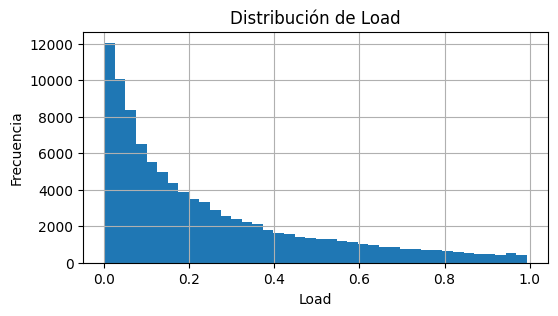

In [14]:
# Histograma de Load
plt.figure(figsize=(6, 3))
df_total['load'].hist(bins=40)
plt.title("Distribución de Load")
plt.xlabel("Load")    # Etiqueta del eje X
plt.ylabel("Frecuencia")                     # Etiqueta del eje Y
plt.show()


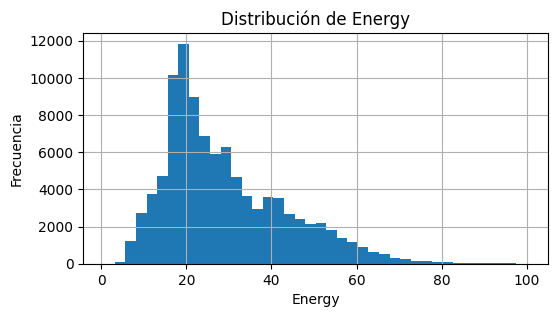

Energy       1.000000
load         0.594971
TXpower      0.309092
Antennas     0.165551
Bandwidth    0.160808
ESMode6      0.120975
Frequency    0.033196
ESMode3      0.013684
ESMode5     -0.004684
ESMode2     -0.267593
ESMode1     -0.269606
ESMode4           NaN
Name: Energy, dtype: float64


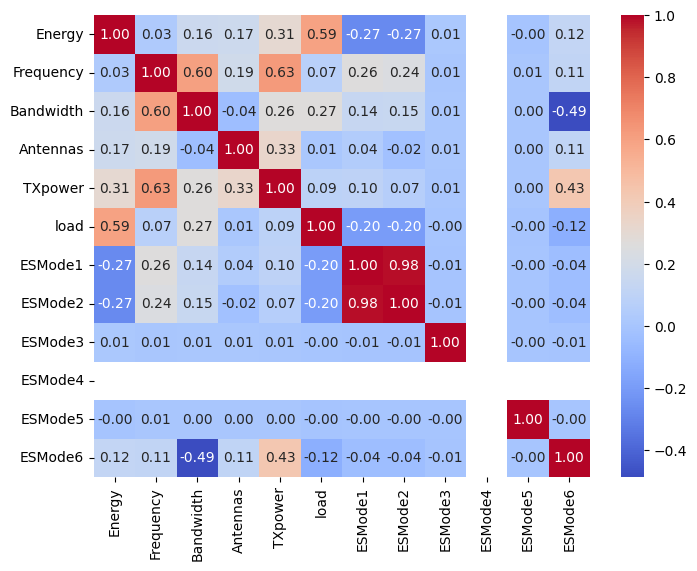

In [46]:
corr = df_total.corr(numeric_only=True)
print(corr['Energy'].sort_values(ascending=False))  # ordenado por relación con Energy

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Relación Load y Energy

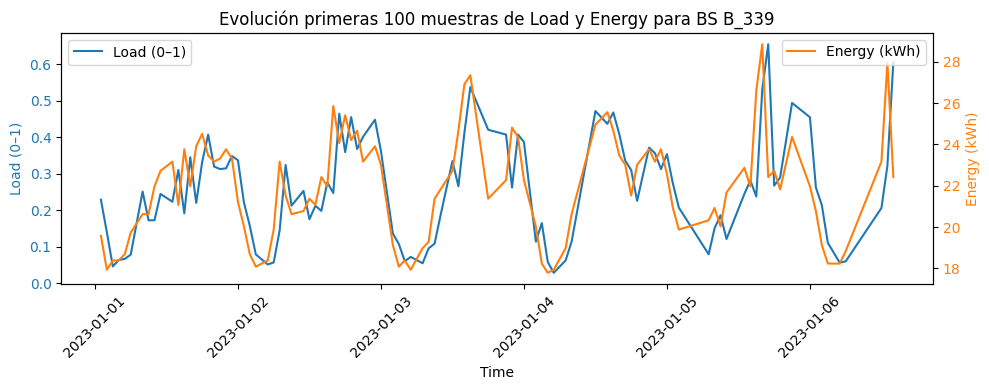

In [47]:
import random

bs_random = random.choice(df_total["BS"].unique().tolist())
df_bs = df_total[df_total["BS"] == bs_random].copy()

# 5) Coge sólo las primeras 100 muestras cronológicas
df_plot = df_bs.iloc[:100]

# 6) Dibuja ambas series sobre el mismo Time
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(df_plot["Time"], df_plot["load"],  color="C0", label="Load (0–1)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Load (0–1)", color="C0")
ax1.tick_params(axis="y", labelcolor="C0")
ax1.tick_params(axis="x", rotation=45)

ax2 = ax1.twinx()
ax2.plot(df_plot["Time"], df_plot["Energy"], color="C1", label="Energy (kWh)")
ax2.set_ylabel("Energy (kWh)", color="C1")
ax2.tick_params(axis="y", labelcolor="C1")

# Leyendas
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.title(f"Evolución primeras 100 muestras de Load y Energy para BS {bs_random}")
plt.tight_layout()
plt.show()

In [48]:
df_total['hour']    = df_total['Time'].dt.hour
df_total['weekday'] = df_total['Time'].dt.weekday
df_total['month']   = df_total['Time'].dt.month

# Elige las columnas que usarás como input
feature_cols = [
    'Frequency','Bandwidth','Antennas','TXpower',   # specs de estación
    'load','ESMode1','ESMode2','ESMode3','ESMode5','ESMode6',  # tráfico y modos
    'hour','weekday','month', 'RUType','Mode'                        # variables temporales
]

X = df_total[feature_cols]
y = df_total['Energy']

In [49]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Supongamos que 'mode' y 'RUType' son categóricas
cat_feats = ['RUType','Mode']
num_feats = [c for c in feature_cols if c not in cat_feats]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(),    num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats),
])

In [69]:
df_test = pd.read_csv('ITU-5G-energy-Consumption-Dataset/power_consumption_prediction.csv')

df_test["Time"] = pd.to_datetime(df_test["Time"])
df_test = df_test.sort_values("Time").reset_index(drop=True)

df_test['hour']    = df_test['Time'].dt.hour
df_test['weekday'] = df_test['Time'].dt.weekday
df_test['month']   = df_test['Time'].dt.month

print(df_test)

                     Time     BS  Energy  w  hour  weekday  month
0     2023-01-01 01:00:00   B_35     NaN  1     1        6      1
1     2023-01-01 01:00:00  B_164     NaN  1     1        6      1
2     2023-01-01 01:00:00  B_537     NaN  1     1        6      1
3     2023-01-01 01:00:00  B_161     NaN  1     1        6      1
4     2023-01-01 01:00:00  B_536     NaN  1     1        6      1
...                   ...    ...     ... ..   ...      ...    ...
26700 2023-01-08 00:00:00  B_794     NaN  1     0        6      1
26701 2023-01-08 00:00:00  B_786     NaN  1     0        6      1
26702 2023-01-08 00:00:00  B_790     NaN  1     0        6      1
26703 2023-01-08 00:00:00  B_729     NaN  1     0        6      1
26704 2023-01-08 00:00:00  B_730     NaN  1     0        6      1

[26705 rows x 7 columns]


In [71]:
X_train = df_total.drop(columns=['Energy'])
y_train = df_total['Energy']
X_test  = df_test.drop(columns=['Energy']) 


                     Time     BS  w  hour  weekday  month
0     2023-01-01 01:00:00   B_35  1     1        6      1
1     2023-01-01 01:00:00  B_164  1     1        6      1
2     2023-01-01 01:00:00  B_537  1     1        6      1
3     2023-01-01 01:00:00  B_161  1     1        6      1
4     2023-01-01 01:00:00  B_536  1     1        6      1
...                   ...    ... ..   ...      ...    ...
26700 2023-01-08 00:00:00  B_794  1     0        6      1
26701 2023-01-08 00:00:00  B_786  1     0        6      1
26702 2023-01-08 00:00:00  B_790  1     0        6      1
26703 2023-01-08 00:00:00  B_729  1     0        6      1
26704 2023-01-08 00:00:00  B_730  1     0        6      1

[26705 rows x 6 columns]
